In [163]:
import os
import librosa
import librosa.display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Flatten, Attention, GlobalMaxPooling1D, Dropout

from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
sns.set()

In [2]:
base_path_train = "train"
fake_path_train = os.path.join(base_path_train, "fake")
real_path_train = os.path.join(base_path_train, "real")

In [3]:
base_path_eval = "dev"
fake_path_eval = os.path.join(base_path_eval, "fake")
real_path_eval = os.path.join(base_path_eval, "real")

In [4]:
base_path_test = "eval"
fake_path_test = os.path.join(base_path_test, "fake")
real_path_test= os.path.join(base_path_test, "real")

In [5]:
def add_noise(data):
    """
    Adds random noise to the audio signal
    """
    noise_factor = np.random.uniform(0.001, 0.01)  # Random noise factor between 0.001 and 0.01
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def stretch(data):
    """
    Stretches the audio signal by a certain rate
    """
    rate = np.random.uniform(0.8, 1.2)
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data, sr):
    """
    Shifts the pitch of the audio signal.
    """
    steps = np.random.randint(-5, 5)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=steps)

def get_appropriate_n_fft(y, max_fft=512):
    return 2 ** int(np.floor(np.log2(min(max_fft, len(y)))))

def extract_features(file_path, augment=False):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Augmentation if enabled
    if augment:
        aug_choice = np.random.choice(['noise', 'stretch', 'pitch'])
        
        if aug_choice == 'noise':
            y = add_noise(data=y)
            
        elif aug_choice == 'stretch':
            y = stretch(data=y)
            
        elif aug_choice == 'pitch':
            y = shift(data=y, sr=sr)
    
    # n_fft = min(512, len(y)) 
    n_fft = get_appropriate_n_fft(y)
    
    # Extract 40 MFCC (Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40, n_fft=n_fft)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    # Extract Additional features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft))
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft))
    
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft)) if len(y) > 12 else 0
    tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr)) if len(y) > 12 else 0
    zero_crossing = np.mean(librosa.feature.zero_crossing_rate(y=y))
    rmse = np.mean(librosa.feature.rms(y=y))
    
    # Combining features into single vector
    features = np.hstack([mfccs_mean, spectral_centroid, spectral_bandwidth,
                         spectral_contrast, spectral_rolloff, chroma, tonnetz,
                         zero_crossing, rmse])
    return features

In [28]:
def load_dataset(fake_path, real_path, train=False, evaluate=False, test=False, num_files=None):
    if train==True: 
        X, y = [], []
        fake_files = [f for f in os.listdir(fake_path) if f.endswith('.wav')]
        real_files = [f for f in os.listdir(real_path) if f.endswith('.wav')]
        
        max_files = max(len(fake_files), len(real_files))
        
        print(f"Fake files: {len(fake_files)}, Real files: {len(real_files)}")
        print(f"Balancing dataset to {max_files} samples each...")
        
        # Load fake files up to max size
        for file_name in tqdm(fake_files, desc="Fake files", unit="file"):
            file_path = os.path.join(fake_path, file_name)
            X.append(extract_features(file_path))
            y.append(1)  # Label for fake
        
        # Load real files up to max size
        for file_name in tqdm(real_files, desc="Real files", unit="file"):
            file_path = os.path.join(real_path, file_name)
            X.append(extract_features(file_path))
            y.append(0)  # Label for real
        
        # If real files are fewer, augment to match max count
        while len(real_files) < max_files:
            file_name = np.random.choice(real_files)
            file_path = os.path.join(real_path, file_name)
            X.append(extract_features(file_path, augment=True))
            y.append(0)  # Augmented real files
            real_files.append(file_name)  # Simulate adding new augmented file
        
        # If fake files are fewer, augment to match max count
        while len(fake_files) < max_files:
            file_name = np.random.choice(fake_files)
            file_path = os.path.join(fake_path, file_name)
            X.append(extract_features(file_path, augment=True))
            y.append(1)  # Augmented fake files
            fake_files.append(file_name)  # Simulate adding new augmented file
        
        print(f"Final dataset: {len(X)} samples (Fake: {sum(y)}, Real: {len(y) - sum(y)})")
        return np.array(X), np.array(y), len(fake_files), len(real_files)

    else:
        X, y = [], []
        fake_files = [f for f in os.listdir(fake_path) if f.endswith('.wav')]
        real_files = [f for f in os.listdir(real_path) if f.endswith('.wav')]

        print(f"Fake files: {len(fake_files)}, Real files: {len(real_files)}")
        print(f"Taking out {num_files} samples each...")

        # Load fake files up to max size
        for file_name in tqdm(fake_files[:num_files], desc="Fake files", unit="file"):
            file_path = os.path.join(fake_path, file_name)
            X.append(extract_features(file_path))
            y.append(1)  # Label for fake
        
        # Load real files up to max size
        for file_name in tqdm(real_files[:num_files], desc="Real files", unit="file"):
            file_path = os.path.join(real_path, file_name)
            X.append(extract_features(file_path))
            y.append(0)  # Label for real

        # If real files are fewer, augment to match max count
        while len(real_files) < num_files:
            file_name = np.random.choice(real_files)
            file_path = os.path.join(real_path, file_name)
            X.append(extract_features(file_path, augment=True))
            y.append(0)  # Augmented real files
            real_files.append(file_name)  # Simulate adding new augmented file
        
        # If fake files are fewer, augment to match max count
        while len(fake_files) < num_files:
            file_name = np.random.choice(fake_files)
            file_path = os.path.join(fake_path, file_name)
            X.append(extract_features(file_path, augment=True))
            y.append(1)  # Augmented fake files
            fake_files.append(file_name)  # Simulate adding new augmented file
            
        return np.array(X), np.array(y)

In [7]:
# Load train data
X, y, fake_files_count, real_files_count = load_dataset(fake_path_train, real_path_train, train=True)

Fake files: 10660, Real files: 2640
Balancing dataset to 10660 samples each...


Real files: 100%|████████████████████████████████████████████████████████████████| 2640/2640 [05:48<00:00,  7.58file/s]


Final dataset: 21320 samples (Fake: 10660, Real: 10660)


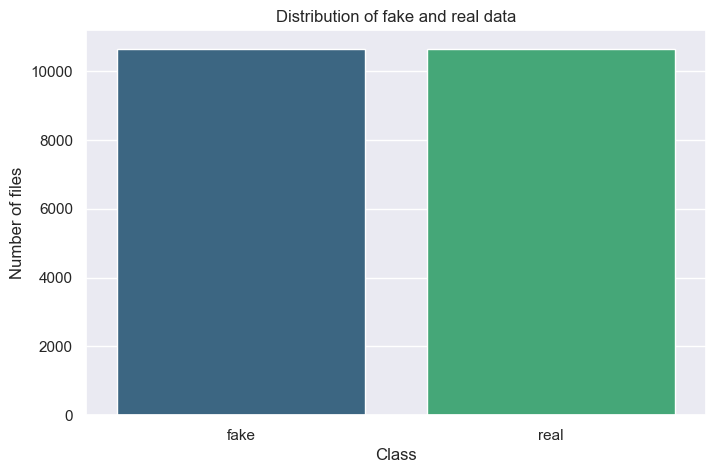

In [8]:
# Visualise the class data

class_label = ['fake', 'real']
class_count = [fake_files_count, real_files_count]

plt.figure(figsize=(8, 5))
sns.barplot(x=class_label, y=class_count, palette = 'viridis')
plt.title("Distribution of fake and real data")
plt.xlabel("Class")
plt.ylabel("Number of files")
plt.show()

In [9]:
# Split dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123, shuffle=True)

In [10]:
# Training a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=123)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [11]:
# Make predictions
rf_pred = rf.predict(X_test)

# Evaluate the model
acc = accuracy_score(y_test, rf_pred)
print(f"Model Accuracy: {acc * 100:.2f}%")

Model Accuracy: 99.04%


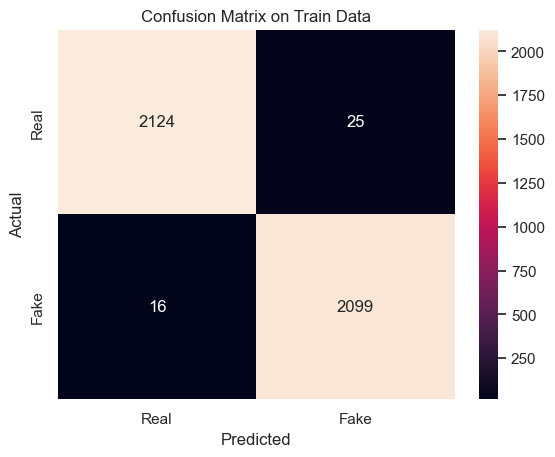

In [13]:
# Plot confusion matrix
cm = confusion_matrix(y_test, rf_pred)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix on Train Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

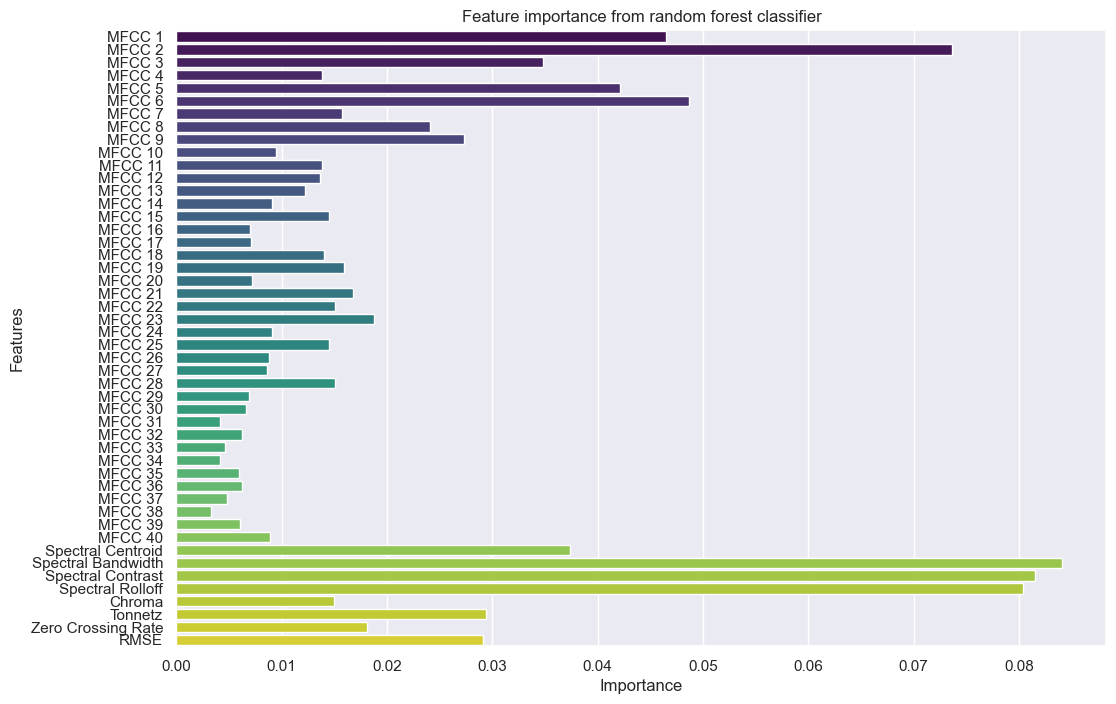

In [14]:
importances = rf.feature_importances_

# Updated feature names
features_names = [f"MFCC {i+1}" for i in range(40)] + ["Spectral Centroid", "Spectral Bandwidth",
                                                       "Spectral Contrast", "Spectral Rolloff",
                                                       "Chroma", "Tonnetz", "Zero Crossing Rate",
                                                       "RMSE"]

# Plot feature importance
plt.figure(figsize=(12,8))
sns.barplot(x=importances, y=features_names, palette = "viridis")
plt.title("Feature importance from random forest classifier")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [15]:
# Shuffle X, y train data as a whole

X1, y1 = shuffle(X, y, random_state=123)

In [148]:
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN layer
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x) 

    # BiLSTM layer
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.1)))(x)
    x = Dropout(0.3)(x) 

    # Attention mechanism
    attention = Attention()([x, x])
    attention = GlobalMaxPooling1D()(attention)

    # Fully connected layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(attention)
    x = Dropout(0.5)(x)
    
    outputs = Dense(1, activation='sigmoid')(x)

    # Model
    model = Model(inputs, outputs)
    return model

In [18]:
X1 = np.expand_dims(X1, axis=2)

In [19]:
X1.shape

(21320, 48, 1)

In [149]:
input_shape = (X1.shape[1], X1.shape[2])

In [150]:
model = build_model(input_shape)

In [151]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [152]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)   │ (None, 48, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_14 (Conv1D)            │ (None, 48, 64)            │             256 │ input_layer_14[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_14              │ (None, 24, 64)            │               0 │ conv1d_14[0][0]            │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_42 (Dropout)          │ (None, 24, 64)            │               0 │ max_pooling1d_14[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_14              │ (None, 24, 128)           │          66,048 │ dropout_42[0][0]           │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_43 (Dropout)          │ (None, 24, 128)           │               0 │ bidirectional_14[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_11 (Attention)      │ (None, 24, 128)           │               0 │ dropout_43[0][0],          │
│                               │                           │                 │ dropout_43[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_13       │ (None, 128)               │               0 │ attention_11[0][0]         │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_28 (Dense)              │ (None, 128)               │          16,512 │ global_max_pooling1d_13[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_44 (Dropout)          │ (None, 128)               │               0 │ dense_28[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_29 (Dense)              │ (None, 1)                 │             129 │ dropout_44[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 82,945 (324.00 KB)

 Trainable params: 82,945 (324.00 KB)

 Non-trainable params: 0 (0.00 B)

In [153]:
history = model.fit(X1, y1, epochs=100, batch_size=50, validation_split=0.2, verbose=1)

Epoch 1/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.5281 - loss: 9.6071 - val_accuracy: 0.6602 - val_loss: 1.0672
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7014 - loss: 0.8737 - val_accuracy: 0.8977 - val_loss: 0.5224
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8427 - loss: 0.5168 - val_accuracy: 0.8166 - val_loss: 0.5634
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8787 - loss: 0.4322 - val_accuracy: 0.8396 - val_loss: 0.4774
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8958 - loss: 0.3864 - val_accuracy: 0.9407 - val_loss: 0.3467
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9089 - loss: 0.3522 - val_accuracy: 0.9350 - val_loss: 0.3338
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9168 - loss: 0.3396 - val_accuracy: 0.9254 - val_loss: 0.3169
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9204 - loss: 0.3218 -

### Validation Data

In [29]:
# Validation Data
X_val, y_val= load_dataset(fake_path_eval, real_path_eval, evaluate=True, num_files=3000)
X_val, y_val = shuffle(X_val, y_val, random_state=123)
X_val = np.expand_dims(X_val, axis=2)

Fake files: 10295, Real files: 2548
Taking out 3000 samples each...


Real files: 100%|████████████████████████████████████████████████████████████████| 2548/2548 [06:01<00:00,  7.04file/s]


In [155]:
# Predicting on validation
y_val_pred = (model.predict(X_val) > 0.5).astype(int)
acc = accuracy_score(y_val, y_val_pred)
print(f"Model Validation Accuracy: {acc * 100:.2f}%")

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Model Validation Accuracy: 90.90%


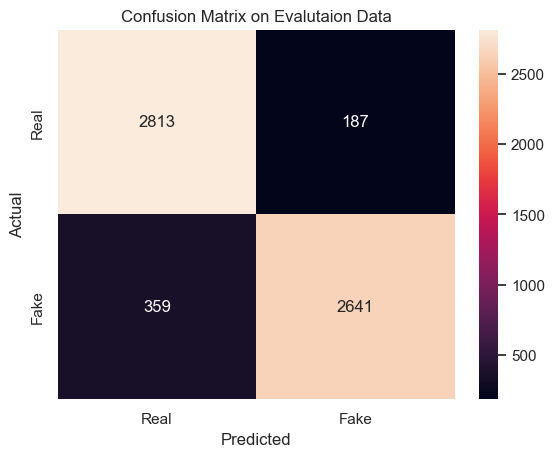

In [156]:
# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix on Evalutaion Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [165]:
# Classification report 
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      3000
           1       0.93      0.88      0.91      3000

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



### Test data

In [33]:
# Test Data
X_test, y_test= load_dataset(fake_path_test, real_path_test, test=True, num_files=3000)
X_test, y_test = shuffle(X_test, y_test, random_state=123)
X_test = np.expand_dims(X_test, axis=2)

Fake files: 26412, Real files: 6334
Taking out 3000 samples each...


Real files: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [07:28<00:00,  6.69file/s]


In [157]:
# Predicting on test data
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, y_test_pred)
print(f"Model Test Accuracy: {acc * 100:.2f}%")

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Model Test Accuracy: 90.38%


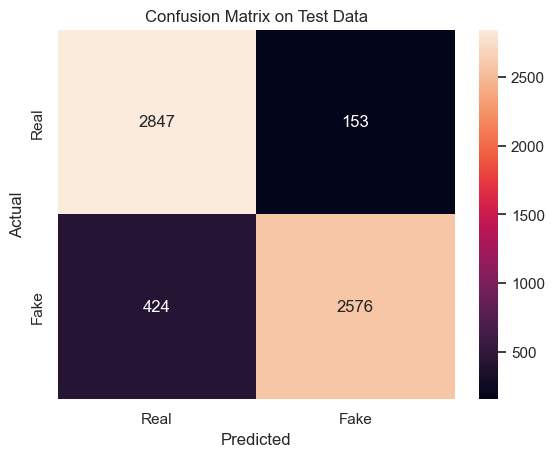

In [158]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix on Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [166]:
# Classification report 
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3000
           1       0.94      0.86      0.90      3000

    accuracy                           0.90      6000
   macro avg       0.91      0.90      0.90      6000
weighted avg       0.91      0.90      0.90      6000

